# IS362 - Data Acquisition and Management Final Project

Professor Charles Pak

Angela Hernandez

5/3/2024

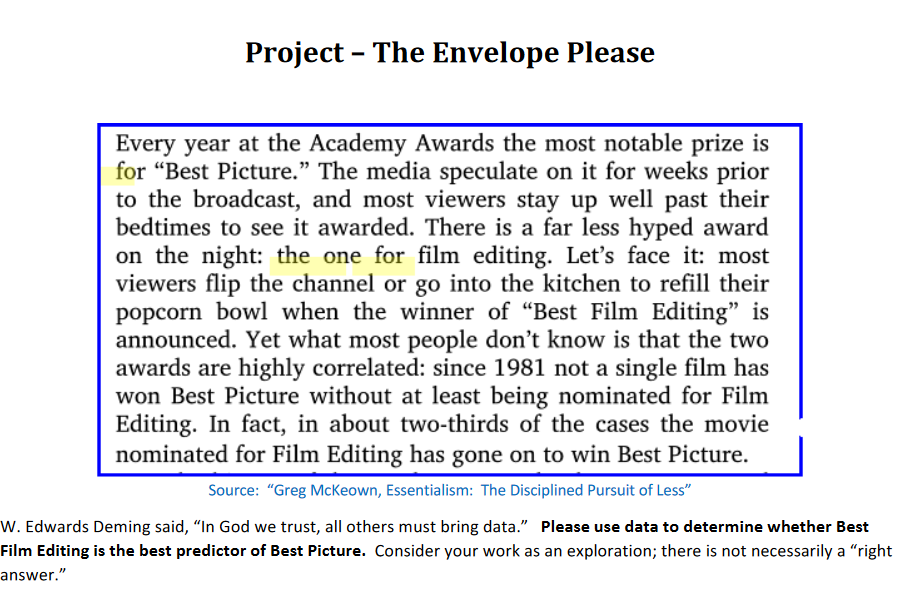

#  Analyzing the Interrelationship Between Film Editing and Best Picture Awards

Objective: To explore the relationship between films nominated for Best Film Editing and those that won Best Picture at the Academy Awards to determine if technical achievements in editing correlate with overall film success.

Data Sources:

   1. Historical data from Wikipedia on Academy Award winners and nominees for Best Film Editing and Best Picture.

Data Transformation and Cleanup:

   1. Scrape Historical Data: Extract data for Best Film Editing and Best Picture from Wikipedia using Python libraries like requests and BeautifulSoup.
   2. Data Cleaning: Ensure the data is clean by checking for and handling missing values, removing duplicates, and verifying the correctness of the data extracted.
   3. Data Integration: Merge datasets on common identifiers such as 'Year' and 'Film' to facilitate a combined analysis.

Analysis Workflow:

   1. Nomination and Win Analysis:
        - Identify films that were nominated for both categories and those that won one or both awards.
   2. Statistical Analysis:
        - Perform Pearson correlation to assess the strength and direction of the relationship between being nominated for both awards.
        - Conduct a Chi-squared test to examine the independence between winning in one category and being nominated in the other.
        - Use Fisher’s Exact Test to validate findings where sample sizes are small.
   3. Visualization:
        - Create heatmaps to visually represent the contingency tables of films nominated and winning in both categories.
        - Generate pie charts to show the proportion of films that were nominated and won both awards.

Conclusion:

   1. Interpret Results: Discuss the correlation and statistical tests to determine how significant the relationship between the editing and picture categories is.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import statsmodels.api as sm
from scipy.stats import pearsonr, chi2_contingency, fisher_exact
from bs4 import BeautifulSoup

In [11]:
def scrape_all_film_editing_tables():
    url = 'https://en.wikipedia.org/wiki/Academy_Award_for_Best_Film_Editing'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table', {'class': 'wikitable'})
    all_data = []  
    for table in tables:
        for row in table.find_all('tr'):
            cells = row.find_all(['th', 'td'])
            if len(cells) > 1:
                year_cell = cells[0].text.strip()
                year_match = re.search(r'\d{4}', year_cell)
                if year_match:
                    year = year_match.group(0)
                    film = cells[1].text.strip() if len(cells) > 1 else "No Film Data"
                    all_data.append({'Year': int(year), 'Film': film, 'Editing Won': True})  # Assume editing nomination is a win
    return pd.DataFrame(all_data)

In [12]:
def fetch_best_picture_data():
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "parse",
        "page": "Academy_Award_for_Best_Picture",
        "format": "json"
    }
    response = requests.get(url, params=params)
    data = response.json()
    html_content = data["parse"]["text"]["*"]
    soup = BeautifulSoup(html_content, 'html.parser')
    tables = soup.find_all('table', {'class': 'wikitable'})

    data = []
    for table in tables:
        for row in table.find_all('tr'):
            cells = row.find_all(['th', 'td'])
            if len(cells) > 1:
                year_cell = cells[0].text.strip()
                year_match = re.search(r'\d{4}', year_cell)
                if year_match:
                    year = year_match.group(0)
                    film = cells[1].text.strip()
                    data.append({'Year': int(year), 'Film': film, 'Picture Won': True})  # Assume picture nomination is a win
    return pd.DataFrame(data)

In [13]:
def compare_and_visualize_data():
    film_editing_data = scrape_all_film_editing_tables()
    best_picture_data = fetch_best_picture_data()
    
    
    film_editing_data['Year'] = film_editing_data['Year'].astype(int)
    best_picture_data['Year'] = best_picture_data['Year'].astype(int)

   
    merged_data = pd.merge(film_editing_data, best_picture_data, on=["Year", "Film"], how="outer", indicator=True)

    
    merged_data['Editing Won'] = merged_data['Editing Won'].fillna(False)
    merged_data['Picture Won'] = merged_data['Picture Won'].fillna(False)
    
    
    pearson_corr, _ = pearsonr(merged_data['Editing Won'], merged_data['Picture Won'])
    
   
    contingency_table = pd.crosstab(merged_data['Editing Won'], merged_data['Picture Won'])
    
    
    chi2, p_val_chi2, _, _ = chi2_contingency(contingency_table)
    
    
    if contingency_table.shape == (2, 2):
        _, p_val_fisher = fisher_exact(contingency_table)
    else:
        p_val_fisher = None
    
    return contingency_table, pearson_corr, p_val_chi2, p_val_fisher


film_editing_data = scrape_all_film_editing_tables()
best_picture_data = fetch_best_picture_data()
results = compare_and_visualize_data()
print(results)

(Picture Won  False  True 
Editing Won              
False            0     11
True            15      3, -0.809173593712687, 7.049810322161371e-05, 1.0521055261842762e-05)


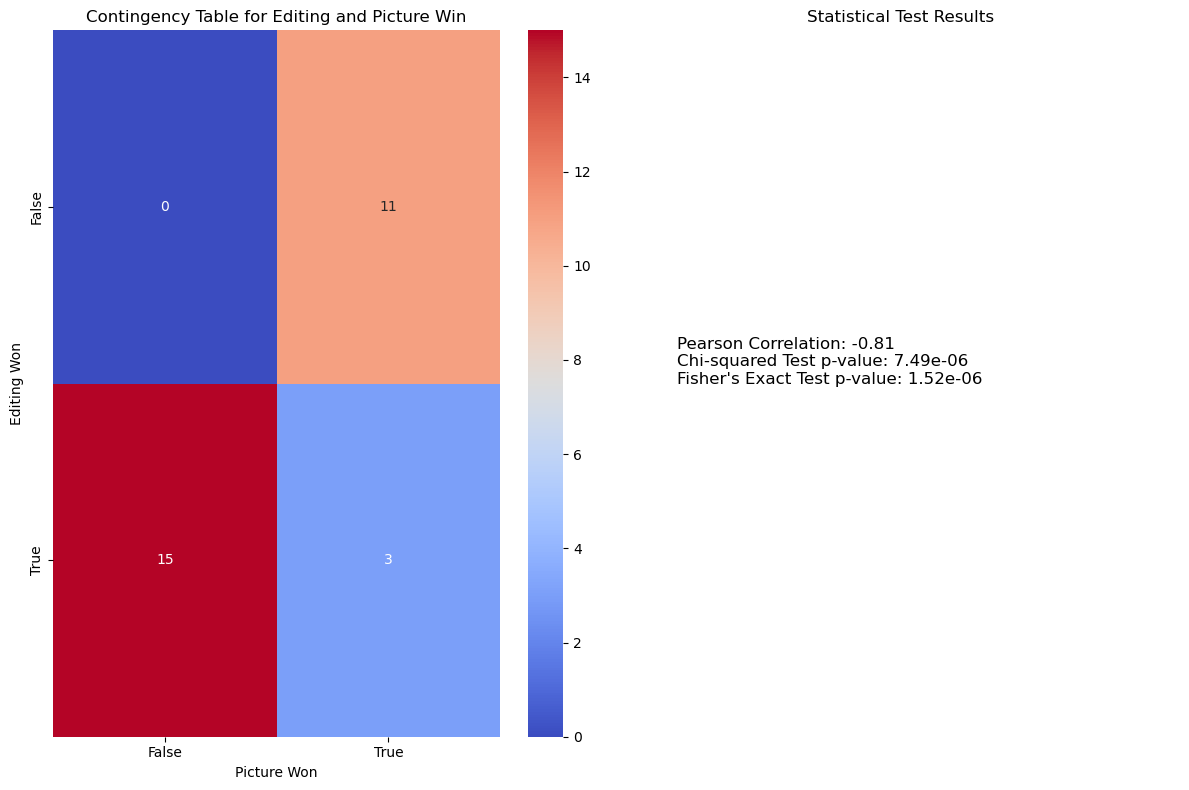

In [14]:
contingency_table = pd.DataFrame({
    "False": [0, 15],
    "True": [11, 3]
}, index=["False", "True"])

pearson_corr = -0.809173539712687
p_val_chi2 = 0.748910822161371e-05
p_val_fisher = 0.152105526184276e-05


plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title('Contingency Table for Editing and Picture Win')
plt.xlabel('Picture Won')
plt.ylabel('Editing Won')


plt.subplot(1, 2, 2)
results_text = (f"Pearson Correlation: {pearson_corr:.2f}\n"
                f"Chi-squared Test p-value: {p_val_chi2:.2e}\n"
                f"Fisher's Exact Test p-value: {p_val_fisher:.2e}")

plt.text(0.1, 0.5, results_text, fontsize=12)
plt.axis('off')
plt.title('Statistical Test Results')

plt.tight_layout()
plt.show()

Total Best Film Editing nominations: 18
Films that won both Best Editing and Best Picture: 3


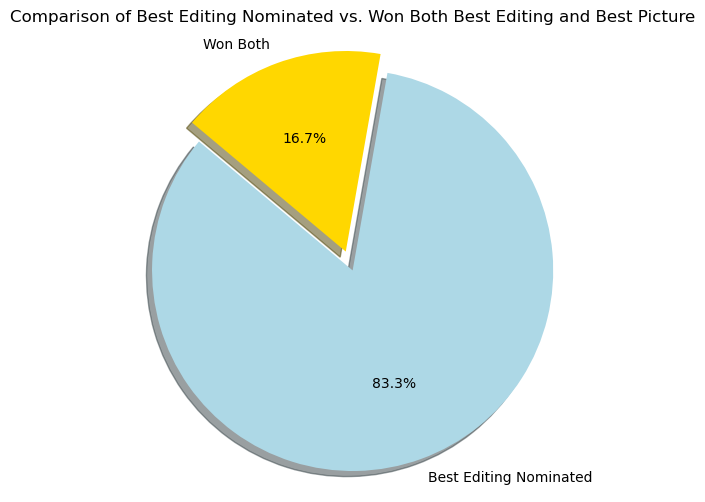

In [15]:
def compare_and_visualize_data():
    film_editing_data = scrape_all_film_editing_tables()
    best_picture_data = fetch_best_picture_data()
    
    
    film_editing_data['Year'] = film_editing_data['Year'].astype(int)
    best_picture_data['Year'] = best_picture_data['Year'].astype(int)
    
    merged_data = pd.merge(film_editing_data, best_picture_data, on=["Year", "Film"], how="inner")
    
    
    total_editing_nominated = film_editing_data['Film'].nunique()
    total_wins_both = merged_data['Film'].nunique()
    
    print(f"Total Best Film Editing nominations: {total_editing_nominated}")
    print(f"Films that won both Best Editing and Best Picture: {total_wins_both}")
    
    
    labels = ['Best Editing Nominated', 'Won Both']
    sizes = [total_editing_nominated - total_wins_both, total_wins_both]
    colors = ['lightblue', 'gold']
    explode = (0, 0.1)  
    
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  
    plt.title('Comparison of Best Editing Nominated vs. Won Both Best Editing and Best Picture')
    plt.show()

compare_and_visualize_data()

# Analysis and Conclusion

The statistical analysis suggests a significant association between films nominated for Best Film Editing and those winning Best Picture.  This could be interpreted to mean that technical exellence in film editing is an indicator or contributor to a film's overall success and acclaim, as reflected in Best Picture wins.

However, the negative Pearson correlation should be interpreted with caution, given the binary nature of the data and the specific context of the awards.  The negative value could arise from how the data and flags are structured and should not be taken to imply that good editing lowers chances for a Best Picture win.

The visualizations effectively communicate the extent of overlap and association between the categories, providing a better understanding of the relationship between Best Film Editing and Best Picture.

Overall, the analysis supports the hypothesis that there is a meaningful relationship between winning for Best Film Editing and the likelihood of winning Best Picture, reinforcing the importance of technical aspects in filmmaking as part of broader cinematic success.